In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# MNIST Classification

In [3]:
# Setup
import sys
from packaging import version
import sklearn

assert sys.version_info >= (3, 7)
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [4]:
# Defining images/classification

from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
# Fetching the MNIST dataset, provided by Scikit-Learn
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False, parser="auto")

In [6]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [7]:
X.shape # 70000 images, 784 features each (images 28x28 pixels, colors 0-255 (white-black))

(70000, 784)

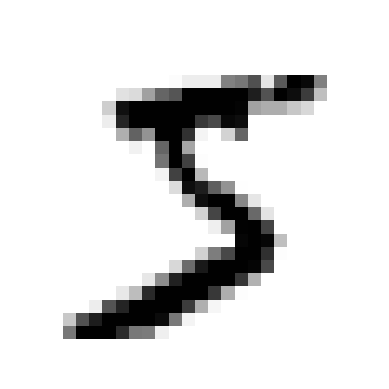

'5'

In [8]:
# Plotting one number (example)
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    
plot_digit(X[0]) # Image [0]
plt.show()
y[0] # Label [0]

In [9]:
# Separating Train and Test sets
X_train, X_test = X[:60000], X[60000:] # Train from 0-5999, test from [6000-7000]
y_train, y_test = y[:60000], y[60000:]

In [10]:
# Binary Classifier for 5 detector
# 5 or non-5
y_train_5 = (y_train == '5') # True if '5'
y_test_5 = (y_test == '5')

In [11]:
# Training the model
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42) # Create the classifier
sgd_clf.fit(X_train, y_train_5) # Train the model with the dataset (predicts only '5s')
sgd_clf.predict([X[0]]) # Verify X[0] (that is a 5)

array([ True])

In [12]:
# Performance measure using cross-validation
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy") # Not the ideal measure

array([0.95035, 0.96035, 0.9604 ])

In [13]:
# Confusion Matrices
# How many times class A is predicted as class B
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) # Return the prediction made for each fold

In [14]:
# Testing the confusion matrices
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_pred) # Target classes, predicted classes
cm
# 53892 correct non-5, 687 wrong 5s (false positive)
# 1891 wrong non-5 (false negative), 3530 correct 5s

array([[53892,   687],
       [ 1891,  3530]])

## Precision & Recall

In [15]:
# Precision of the classifier, metrics
# Precision = TruePositive / (TruePositive + FalsePositive)
# If no FalsePositive then precision 1/1, but only gets the positives
from sklearn.metrics import precision_score

precision_score(y_train_5, y_train_pred) # 3530 / (3530 + 687)
# It is correct only %83,7

0.8370879772350012

In [16]:
# Recall = TruePositive / (TruePositive + FalseNegative)
# If no FalseNegative then precision 1/1
# The closest to 0 the worst
from sklearn.metrics import recall_score

recall_score(y_train_5, y_train_pred) # 3530 / (3530 + 1891)
# Only gets %65,1 of the 5s

0.6511713705958311

In [17]:
# Combining the metrics
# F1 Score is the harmonic mean of both precision and recall
# F1 = 2 / ((1 / Precision) + (1 / Recall)) = TP / (TP + ((FN + FP) / 2))
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [18]:
# Decision score
y_scores = sgd_clf.decision_function([X[0]])
y_scores # Gives the score of firts image

array([2164.22030239])

In [19]:
threshold = 0
y_some_digit_pred = (y_scores > threshold) # Limits how much the score must be
y_some_digit_pred

array([ True])

In [20]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [21]:
# Deciding with threshold to use
# First train the model i.e. using cross_val_predict, to get all instances scores
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function") # Gives the scores for each instance

In [22]:
# Testing how precision and recall vari for different thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

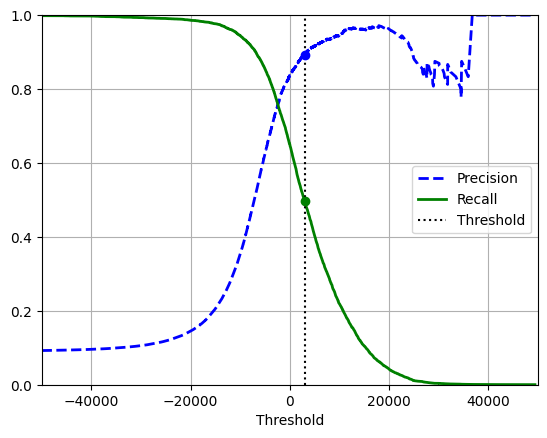

In [23]:
# Using Matplotlib to plot precision and recall as functions of the threshold value
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="Threshold")

idx = (thresholds >= threshold).argmax()
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

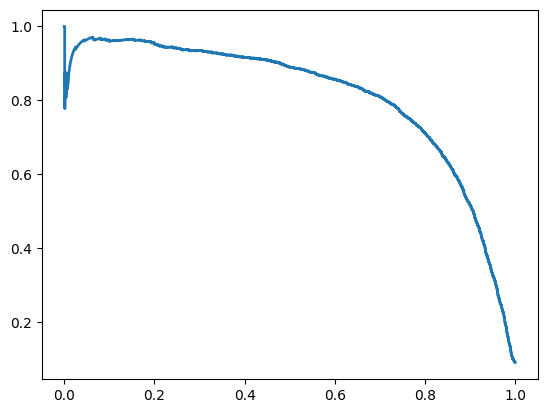

In [24]:
# Precision for Recall garphics
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.show()
# Precision falls at 80% recall

In [25]:
# Finding the threshold value for 90% precision
idx_for_90_precision = (precisions >= 0.90).argmax() # First index of the maximum value (first True)
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.0194991439594

In [26]:
# Making predictions
# Precision
y_train_pred_90 = (y_scores >= threshold_for_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [27]:
# Recall
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision # Recall is too low to bem considered a good classifier

0.4799852425751706

In [28]:
# ROC (Receiver Operating Characteristic) Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

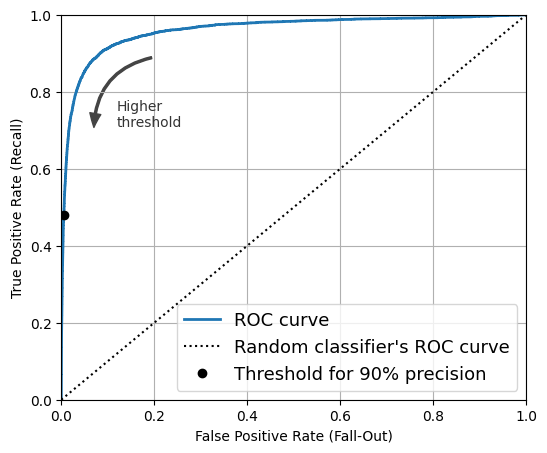

In [29]:
# Ploting ROC Curve
import matplotlib.patches as patches

idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()

# TPR must be the closest to 1, and FPR must be closest to 0 -> (0,1)

In [30]:
# ROC AUC (Area Under the (ROC) Curve)
# Closest to 1 the better, less than 0,5 is bad
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008617

In [31]:
# Training a RandomForestClassifier and comparing to the SGD Classifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [32]:
# Using cross val predict and getting the prediction probalities as the score
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [33]:
# Printing the estimated probalities
y_probas_forest[:5] # [chance of non-5, chance of 5]

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       [1.  , 0.  ],
       [0.99, 0.01]])

In [34]:
y_scores_forest = y_probas_forest[:, 1] # Only the predicted positive 5s
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

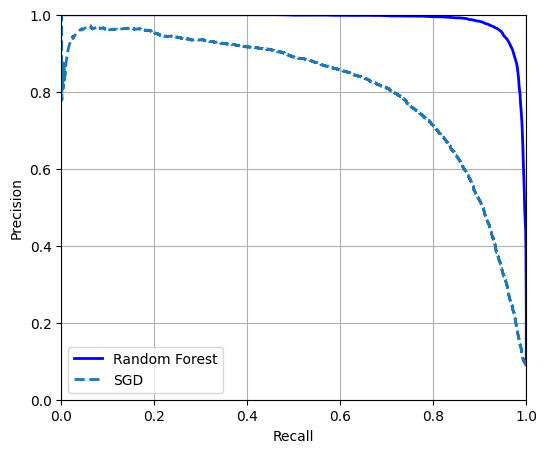

In [35]:
# Plotting te PR curve, comparting SGD and Random Forest
plt.figure(figsize=(6, 5))

plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2,
         label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()
# Closer to top-right the better, both (1, 1)

In [36]:
# F1 Score
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [37]:
# Area Under the Curve
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification

In [38]:
# Multiclasses can distinguish more than 2 classes
# Not only 5s and non-5s, but all 0-9
# Training a SVM Classifier (Suport Vector Machine Classifier)
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) # Only 2000 images

SVC(random_state=42)

In [39]:
# Testing the trained model
svm_clf.predict([X[0]])

array(['5'], dtype=object)

In [40]:
# 10 scores, one for each number (0-9), the highest is the predicted
digit0_score = svm_clf.decision_function([X[0]])
digit0_score.round(2) # The 9.3 corresponds to '5' witch is corect

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

In [41]:
# Showing the classes of the classifier
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [42]:
# Training a one-vs-rest classifier
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [43]:
ovr_clf.predict([X[0]])

array(['5'], dtype='<U1')

In [44]:
# Training a SGD Classifier on multiclass
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([X[0]]) # Predicts wrong

array(['3'], dtype='<U1')

In [45]:
# Trained 10 binary classifiers, one for each number, these are the scores
sgd_clf.decision_function([X[0]]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [46]:
# Using cross val score to evaluate the model
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [47]:
# Scaling the imputers to get better results
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64"))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Error Analysis

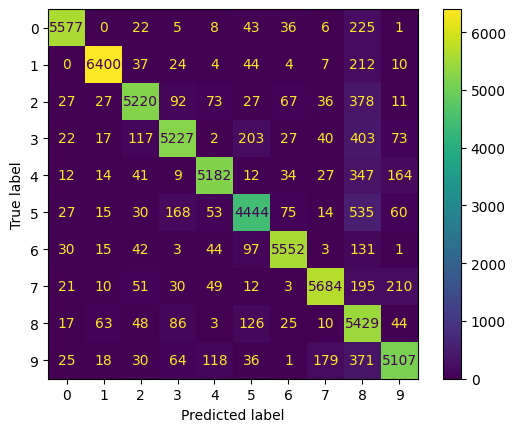

In [48]:
# Colored diagram of the Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show() # Looks like a good model

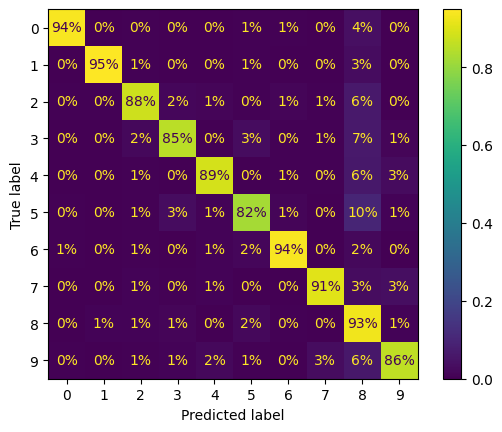

In [49]:
# Normalazing the Confusion Matrix (divide each value for the number of true values)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize="true", values_format=".0%") 
# Shows the % of accuracy for each number, and the % of wrong predictions, (ex: only 82% of the 5s were predicetd correctly)
plt.show()

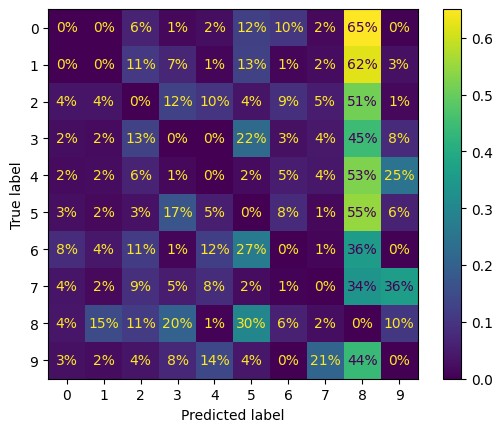

In [50]:
# Turning the mistakes more visible, graphics with errors only
sample_weight = (y_train_pred != y_train) # Excluding the correct predictions
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize="true", values_format=".0%")
plt.show()

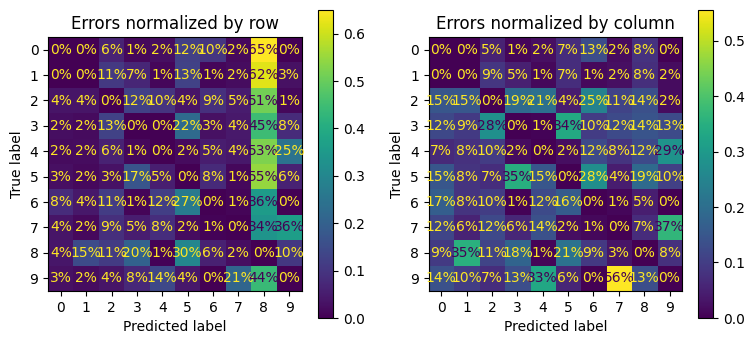

In [51]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
plt.rc('font', size=10)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], sample_weight=sample_weight, normalize="true", values_format=".0%")
axs[0].set_title("Errors normalized by row")
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[1], sample_weight=sample_weight, normalize="pred", values_format=".0%")
axs[1].set_title("Errors normalized by column")
plt.show() # 56% of the classified 7s are acctualy 9s
plt.rc('font', size=14)

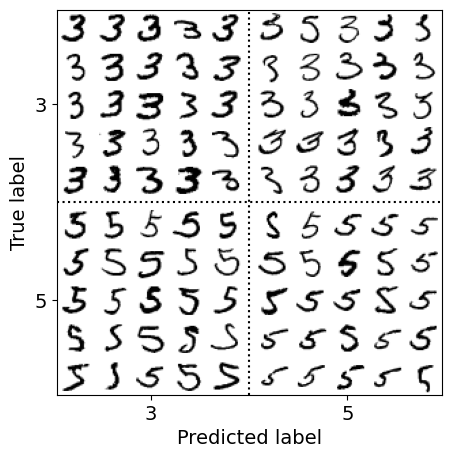

In [52]:
# By the response of the diagrams, the false 8s need to be reduced for example
# Plotting 3s and 5s to analyze
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

## Multilabel Classification

In [55]:
# Classify more than one class for an istance
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= '7') # Get the numbers labeled as 7 or above
y_train_odd = (y_train.astype('int8') % 2 == 1) # Get the odd numbers
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [56]:
knn_clf.predict([X[0]]) # Predicts first if its +7, then if is odd

array([[False,  True]])

In [58]:
# Evaluating the KNN Classifier
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro") 
# This assumes that all labels are equally important

0.976410265560605

In [60]:
f1_score(y_multilabel, y_train_knn_pred, average="weighted") # Gives each label a weight equals to its number of instances

0.9778357403921755

In [61]:
# Chain Classifier uses all prediction already done, plus the input features to do newer predictions
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

In [62]:
chain_clf.predict([X[0]])

array([[0., 1.]])

## Multioutput Classification

In [64]:
# Each label can be assigned for more than one class
# Using it to remove the noise of the images, each pixel will be classified a intensity that ranges 0 to 255
np.random.seed(42)
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

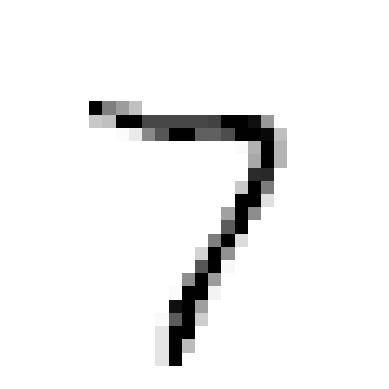

In [65]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod) # KNN to predict the pixel intensity and clear the noise
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show() # Plotting the cleaned number